In [ ]:
!pip install --upgrade pip setuptools wheel

# Core data processing


# PySpark and Spark NLP
!pip install pyspark==3.5.0
!pip install spark-nlp==5.1.4

# FastAPI and web server
!pip install fastapi==0.104.1
!pip install uvicorn[standard]==0.24.0
!pip install pydantic==2.5.0

# HTTP and utilities
!pip install requests==2.31.0

# Vector search and embeddings
!pip install faiss-cpu==1.7.4
!pip install sentence-transformers==2.2.2

# Ngrok for public API
!pip install pyngrok==7.0.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 15.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [watchfiles]
ERROR: Could not find a version that satisfies the requirement faiss-cpu==1.7.4 (from versions: 1.8.0, 1.8.0.post1, 1.9.0, 1.9.0.post1, 1.10.0, 1.11.0, 1.11.0.post1, 1.12.0)
ERROR: No matching distribution found for faiss-cpu==1.7.4


In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 75.8 MB/s  0:00:00


In [ ]:
!pip install sentence-transformers --upgrade

  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 2.2.2
    Uninstalling sentence-transformers-2.2.2:
      Successfully uninstalled sentence-transformers-2.2.2


In [ ]:
# ============================================================================
# SECTION 2: Import Libraries
# ============================================================================

import os
import json
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from typing import List, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, explode, split, regexp_extract, lower, when
from pyspark.sql.types import StringType, FloatType, StructType, StructField, TimestampType

# Spark NLP imports
import sparknlp
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import SentenceDetector, Tokenizer, NerDLModel, NerConverter

# Vector storage
import faiss
from sentence_transformers import SentenceTransformer

# FastAPI
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import uvicorn
from pyngrok import ngrok
import nest_asyncio

# Enable async operations in Colab
nest_asyncio.apply()

print("✅ Libraries imported successfully!")

print("🔥 Initializing Spark Session with Spark NLP...")

spark = sparknlp.start()

print(f"✅ Spark Version: {spark.version}")
print(f"✅ Spark NLP Version: {sparknlp.version()}")


class USGSDataCollector:
    """Collects earthquake data from USGS API"""

    def __init__(self):
        self.base_url = "https://earthquake.usgs.gov/fdsnws/event/1/query"

    def fetch_earthquakes(self,
                         start_time: str = None,
                         end_time: str = None,
                         min_magnitude: float = 4.0,
                         limit: int = 1000) -> List[Dict]:


        # Default to last 30 days if not specified
        if not end_time:
            end_time = datetime.now().strftime('%Y-%m-%d')
        if not start_time:
            start_time = (datetime.now() - timedelta(days=30)).strftime('%Y-%m-%d')

        params = {
            'format': 'geojson',
            'starttime': start_time,
            'endtime': end_time,
            'minmagnitude': min_magnitude,
            'limit': limit,
            'orderby': 'time-asc'
        }

        print(f"🌍 Fetching earthquakes from {start_time} to {end_time}...")

        try:
            response = requests.get(self.base_url, params=params, timeout=30)
            response.raise_for_status()
            data = response.json()

            earthquakes = []
            for feature in data.get('features', []):
                props = feature['properties']
                coords = feature['geometry']['coordinates']

                earthquake = {
                    'id': feature['id'],
                    'magnitude': float(props.get('mag')) if props.get('mag') is not None else None,
                    'place': props.get('place'),
                    'time': float(props.get('time')) if props.get('time') is not None else None,
                    'updated': float(props.get('updated')) if props.get('updated') is not None else None,
                    'timezone': float(props.get('tz')) if props.get('tz') is not None else None,
                    'url': props.get('url'),
                    'detail': props.get('detail'),
                    'felt': float(props.get('felt')) if props.get('felt') is not None else None,
                    'cdi': float(props.get('cdi')) if props.get('cdi') is not None else None,
                    'mmi': float(props.get('mmi')) if props.get('mmi') is not None else None,
                    'alert': props.get('alert'),
                    'status': props.get('status'),
                    'tsunami': float(props.get('tsunami')) if props.get('tsunami') is not None else None,
                    'sig': float(props.get('sig')) if props.get('sig') is not None else None,
                    'net': props.get('net'),
                    'code': props.get('code'),
                    'ids': props.get('ids'),
                    'sources': props.get('sources'),
                    'types': props.get('types'),
                    'nst': float(props.get('nst')) if props.get('nst') is not None else None,
                    'dmin': float(props.get('dmin')) if props.get('dmin') is not None else None,
                    'rms': float(props.get('rms')) if props.get('rms') is not None else None,
                    'gap': float(props.get('gap')) if props.get('gap') is not None else None,
                    'magType': props.get('magType'),
                    'type': props.get('type'),
                    'title': props.get('title'),
                    'longitude': float(coords[0]) if coords[0] is not None else None,
                    'latitude': float(coords[1]) if coords[1] is not None else None,
                    'depth': float(coords[2]) if coords[2] is not None else None
                }
                earthquakes.append(earthquake)

            print(f"✅ Successfully fetched {len(earthquakes)} earthquakes")
            return earthquakes

        except Exception as e:
            print(f"❌ Error fetching data: {e}")
            return []

class EarthquakeETL:
    """ETL pipeline for earthquake data processing"""

    def __init__(self, spark_session):
        self.spark = spark_session

    def create_dataframe(self, data: List[Dict]):
        """Convert raw data to Spark DataFrame"""
        if not data:
            print("⚠️ No data to process")
            return None

        # Define explicit schema to handle mixed types
        schema = StructType([
            StructField("id", StringType(), True),
            StructField("magnitude", FloatType(), True),
            StructField("place", StringType(), True),
            StructField("time", FloatType(), True),
            StructField("updated", FloatType(), True),
            StructField("timezone", FloatType(), True),
            StructField("url", StringType(), True),
            StructField("detail", StringType(), True),
            StructField("felt", FloatType(), True),
            StructField("cdi", FloatType(), True),
            StructField("mmi", FloatType(), True),
            StructField("alert", StringType(), True),
            StructField("status", StringType(), True),
            StructField("tsunami", FloatType(), True),
            StructField("sig", FloatType(), True),
            StructField("net", StringType(), True),
            StructField("code", StringType(), True),
            StructField("ids", StringType(), True),
            StructField("sources", StringType(), True),
            StructField("types", StringType(), True),
            StructField("nst", FloatType(), True),
            StructField("dmin", FloatType(), True),
            StructField("rms", FloatType(), True),
            StructField("gap", FloatType(), True),
            StructField("magType", StringType(), True),
            StructField("type", StringType(), True),
            StructField("title", StringType(), True),
            StructField("longitude", FloatType(), True),
            StructField("latitude", FloatType(), True),
            StructField("depth", FloatType(), True)
        ])

        df = self.spark.createDataFrame(data, schema=schema)
        print(f"✅ Created DataFrame with {df.count()} records")
        return df

    def clean_and_transform(self, df):
        """Clean and transform earthquake data"""
        print("🧹 Cleaning and transforming data...")

        # Convert timestamp from milliseconds to datetime
        df = df.withColumn('timestamp',
                          (col('time') / 1000).cast('timestamp'))

        df = df.withColumn('updated_timestamp',
                          (col('updated') / 1000).cast('timestamp'))

        # Extract location information
        df = df.withColumn('location_clean',
                          regexp_extract(col('place'), r'of (.+)$', 1))

        df = df.withColumn('distance_from_location',
                          regexp_extract(col('place'), r'^(\d+)km', 1))

        # Create magnitude categories
        df = df.withColumn('magnitude_category',
            when(col('magnitude') < 5.0, 'Minor')
            .when((col('magnitude') >= 5.0) & (col('magnitude') < 6.0), 'Moderate')
            .when((col('magnitude') >= 6.0) & (col('magnitude') < 7.0), 'Strong')
            .when((col('magnitude') >= 7.0) & (col('magnitude') < 8.0), 'Major')
            .otherwise('Great'))

        # Create depth categories
        df = df.withColumn('depth_category',
            when(col('depth') < 70, 'Shallow')
            .when((col('depth') >= 70) & (col('depth') < 300), 'Intermediate')
            .otherwise('Deep'))

        # Select and order columns
        df = df.select(
            'id', 'timestamp', 'magnitude', 'magnitude_category',
            'place', 'location_clean', 'latitude', 'longitude',
            'depth', 'depth_category', 'type', 'title',
            'alert', 'tsunami', 'felt', 'sig', 'status', 'url'
        )

        print(f"✅ Cleaned data: {df.count()} records")
        return df

    def get_summary_statistics(self, df):
        """Generate summary statistics"""
        print("\n📊 Summary Statistics:")
        print("=" * 60)

        # Basic stats
        print(f"Total Earthquakes: {df.count()}")
        print(f"\nMagnitude Range: {df.agg({'magnitude': 'min'}).collect()[0][0]:.2f} - {df.agg({'magnitude': 'max'}).collect()[0][0]:.2f}")
        print(f"Average Magnitude: {df.agg({'magnitude': 'avg'}).collect()[0][0]:.2f}")

        # Category distribution
        print("\n📈 Magnitude Distribution:")
        df.groupBy('magnitude_category').count().orderBy('count', ascending=False).show()

        print("\n🌊 Depth Distribution:")
        df.groupBy('depth_category').count().orderBy('count', ascending=False).show()

        print("\n🚨 Alert Levels:")
        df.groupBy('alert').count().orderBy('count', ascending=False).show()

        return df


class EarthquakeNLPProcessor:
    """Natural Language Processing for earthquake descriptions"""

    def __init__(self, spark_session):
        self.spark = spark_session

    def build_nlp_pipeline(self):
        """Build Spark NLP pipeline for entity extraction"""
        print("🧠 Building NLP Pipeline...")

        # Document Assembler
        document_assembler = DocumentAssembler() \
            .setInputCol("title") \
            .setOutputCol("document")

        # Sentence Detector
        sentence_detector = SentenceDetector() \
            .setInputCols(["document"]) \
            .setOutputCol("sentence")

        # Tokenizer
        tokenizer = Tokenizer() \
            .setInputCols(["sentence"]) \
            .setOutputCol("token")

        # Create simple pipeline (NER models are large, using basic pipeline for Colab)
        from pyspark.ml import Pipeline

        pipeline = Pipeline(stages=[
            document_assembler,
            sentence_detector,
            tokenizer
        ])

        print("✅ NLP Pipeline created")
        return pipeline

    def process_text(self, df):
        """Process earthquake descriptions with NLP"""
        print("📝 Processing text data...")

        # Filter out null titles
        df_with_text = df.filter(col('title').isNotNull())

        pipeline = self.build_nlp_pipeline()
        model = pipeline.fit(df_with_text)
        result = model.transform(df_with_text)

        print("✅ Text processing complete")
        return result

class EarthquakeVectorStore:
    """Vector database for semantic search"""

    def __init__(self):
        print("🔍 Initializing Sentence Transformer...")
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        self.index = None
        self.documents = []
        self.metadata = []

    def create_embeddings(self, df_pandas: pd.DataFrame):
        """Create embeddings for earthquake data"""
        print("🎯 Creating embeddings...")

        # Create text representations
        texts = []
        for _, row in df_pandas.iterrows():
            text = f"Magnitude {row['magnitude']} earthquake {row['place']} at depth {row['depth']}km"
            texts.append(text)
            self.metadata.append(row.to_dict())

        self.documents = texts

        # Generate embeddings
        embeddings = self.model.encode(texts, show_progress_bar=True)

        # Create FAISS index
        dimension = embeddings.shape[1]
        self.index = faiss.IndexFlatL2(dimension)
        self.index.add(embeddings.astype('float32'))

        print(f"✅ Created vector store with {len(texts)} embeddings")

    def search(self, query: str, top_k: int = 5):
        """Semantic search for earthquakes"""
        if self.index is None:
            return []

        # Encode query
        query_vector = self.model.encode([query])

        # Search
        distances, indices = self.index.search(query_vector.astype('float32'), top_k)

        results = []
        for idx, dist in zip(indices[0], distances[0]):
            if idx < len(self.metadata):
                result = self.metadata[idx].copy()
                result['similarity_score'] = float(1 / (1 + dist))
                results.append(result)

        return results


vector_store = None
earthquake_df = None

app = FastAPI(
    title="USGS Earthquake Intelligence API",
    description="Real-time earthquake data with semantic search",
    version="1.0.0"
)

class QueryRequest(BaseModel):
    query: str
    top_k: int = 5

class StatsRequest(BaseModel):
    min_magnitude: Optional[float] = None
    max_magnitude: Optional[float] = None

@app.get("/")
def root():
    """API root endpoint"""
    return {
        "message": "USGS Earthquake Intelligence API",
        "version": "1.0.0",
        "endpoints": {
            "/search": "Semantic search for earthquakes",
            "/recent": "Get recent earthquakes",
            "/stats": "Get statistics",
            "/magnitude/{mag}": "Get earthquakes by magnitude"
        }
    }

@app.post("/search")
def search_earthquakes(request: QueryRequest):
    """Semantic search endpoint"""
    if vector_store is None:
        raise HTTPException(status_code=503, detail="Vector store not initialized")

    results = vector_store.search(request.query, request.top_k)

    return {
        "query": request.query,
        "results_count": len(results),
        "results": results
    }

@app.get("/recent")
def get_recent_earthquakes(limit: int = 10):
    """Get most recent earthquakes"""
    if earthquake_df is None:
        raise HTTPException(status_code=503, detail="Data not loaded")

    recent = earthquake_df.nlargest(limit, 'timestamp')
    return {
        "count": len(recent),
        "earthquakes": recent.to_dict('records')
    }

@app.get("/magnitude/{magnitude}")
def get_by_magnitude(magnitude: float, tolerance: float = 0.5):
    """Get earthquakes by magnitude range"""
    if earthquake_df is None:
        raise HTTPException(status_code=503, detail="Data not loaded")

    filtered = earthquake_df[
        (earthquake_df['magnitude'] >= magnitude - tolerance) &
        (earthquake_df['magnitude'] <= magnitude + tolerance)
    ]

    return {
        "magnitude_range": f"{magnitude - tolerance} - {magnitude + tolerance}",
        "count": len(filtered),
        "earthquakes": filtered.to_dict('records')
    }

@app.post("/stats")
def get_statistics(request: StatsRequest):
    """Get earthquake statistics"""
    if earthquake_df is None:
        raise HTTPException(status_code=503, detail="Data not loaded")

    df = earthquake_df.copy()

    if request.min_magnitude:
        df = df[df['magnitude'] >= request.min_magnitude]
    if request.max_magnitude:
        df = df[df['magnitude'] <= request.max_magnitude]

    return {
        "total_count": len(df),
        "magnitude_stats": {
            "min": float(df['magnitude'].min()),
            "max": float(df['magnitude'].max()),
            "mean": float(df['magnitude'].mean()),
            "median": float(df['magnitude'].median())
        },
        "depth_stats": {
            "min": float(df['depth'].min()),
            "max": float(df['depth'].max()),
            "mean": float(df['depth'].mean())
        },
        "category_distribution": df['magnitude_category'].value_counts().to_dict()
    }



def run_earthquake_pipeline():
    """Execute complete earthquake intelligence pipeline"""

    print("\n" + "="*70)
    print("🌍 USGS EARTHQUAKE INTELLIGENCE ASSISTANT")
    print("="*70 + "\n")

    global vector_store, earthquake_df

    # Step 1: Collect Data
    print("\n📡 STEP 1: Data Collection")
    print("-" * 70)
    collector = USGSDataCollector()
    raw_data = collector.fetch_earthquakes(min_magnitude=4.5, limit=500)

    if not raw_data:
        print("❌ No data collected. Exiting.")
        return

    # Step 2: ETL Processing
    print("\n⚙️ STEP 2: ETL Processing")
    print("-" * 70)
    etl = EarthquakeETL(spark)
    df = etl.create_dataframe(raw_data)
    df_clean = etl.clean_and_transform(df)
    df_clean = etl.get_summary_statistics(df_clean)

    # Step 3: NLP Processing
    print("\n🧠 STEP 3: NLP Processing")
    print("-" * 70)
    nlp_processor = EarthquakeNLPProcessor(spark)
    df_nlp = nlp_processor.process_text(df_clean)

    # Convert to Pandas for vector store
    df_pandas = df_clean.toPandas()

    # Convert timestamp to string for JSON serialization
    df_pandas['timestamp'] = df_pandas['timestamp'].astype(str)
    earthquake_df = df_pandas

    # Step 4: Create Vector Store
    print("\n🔍 STEP 4: Vector Store Creation")
    print("-" * 70)
    vector_store = EarthquakeVectorStore()
    vector_store.create_embeddings(df_pandas)

    # Step 5: Test Semantic Search
    print("\n🔎 STEP 5: Testing Semantic Search")
    print("-" * 70)
    test_queries = [
        "large earthquakes in Pacific",
        "shallow earthquakes near Japan",
        "recent strong tremors in Indonesia"
    ]

    for query in test_queries:
        print(f"\n Query: '{query}'")
        results = vector_store.search(query, top_k=3)
        for i, result in enumerate(results, 1):
            print(f"  {i}. {result['title']} (Score: {result['similarity_score']:.3f})")

    print("\n" + "="*70)
    print("✅ PIPELINE EXECUTION COMPLETE!")
    print("="*70)

    return df_pandas, vector_store



def start_api_server():
    """Start FastAPI server with ngrok tunnel"""

    print("\n🚀 Starting FastAPI Server...")
    print("-" * 70)

    # Set up ngrok tunnel
    ngrok.set_auth_token("YOUR_NGROK_TOKEN")  # Replace with your token
    public_url = ngrok.connect(8000)

    print(f"✅ API Server Running!")
    print(f"🌐 Public URL: {public_url}")
    print(f"📚 API Docs: {public_url}/docs")
    print(f"📖 Interactive API: {public_url}/redoc")
    print("\nAvailable Endpoints:")
    print("  GET  /              - API information")
    print("  POST /search        - Semantic search")
    print("  GET  /recent        - Recent earthquakes")
    print("  GET  /magnitude/{m} - Search by magnitude")
    print("  POST /stats         - Get statistics")
    print("\n⚠️  Note: Replace 'YOUR_NGROK_TOKEN' with actual token")
    print("-" * 70)

    # Run server
    uvicorn.run(app, host="0.0.0.0", port=8000)



if __name__ == "__main__":
    # Run the complete pipeline
    df_result, vs = run_earthquake_pipeline()

    print("\n" + "="*70)
    print("📊 SAMPLE DATA")
    print("="*70)
    print(df_result.head(10))

    print("\n" + "="*70)
    print("🎯 NEXT STEPS")
    print("="*70)
    print("1. Review the data and statistics above")
    print("2. To start the API server, run: start_api_server()")
    print("3. Get ngrok token from: https://dashboard.ngrok.com/get-started/your-authtoken")
    print("4. Test semantic search with custom queries")
    print("5. Access API documentation at /docs endpoint")
    print("="*70)

✅ Libraries imported successfully!
🔥 Initializing Spark Session with Spark NLP...
✅ Spark Version: 3.5.0
✅ Spark NLP Version: 5.1.4

🌍 USGS EARTHQUAKE INTELLIGENCE ASSISTANT


📡 STEP 1: Data Collection
----------------------------------------------------------------------
🌍 Fetching earthquakes from 2025-09-08 to 2025-10-08...
✅ Successfully fetched 500 earthquakes

⚙️ STEP 2: ETL Processing
----------------------------------------------------------------------
✅ Created DataFrame with 500 records
🧹 Cleaning and transforming data...
✅ Cleaned data: 500 records

📊 Summary Statistics:
Total Earthquakes: 500

Magnitude Range: 4.50 - 7.80
Average Magnitude: 4.86

📈 Magnitude Distribution:
+------------------+-----+
|magnitude_category|count|
+------------------+-----+
|             Minor|  348|
|          Moderate|  142|
|            Strong|    8|
|             Major|    2|
+------------------+-----+


🌊 Depth Distribution:
+--------------+-----+
|depth_category|count|
+--------------+----

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🎯 Creating embeddings...


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

✅ Created vector store with 500 embeddings

🔎 STEP 5: Testing Semantic Search
----------------------------------------------------------------------

 Query: 'large earthquakes in Pacific'
  1. M 4.9 - central East Pacific Rise (Score: 0.587)
  2. M 4.9 - 208 km N of Fais, Micronesia (Score: 0.578)
  3. M 4.6 - Fiji region (Score: 0.578)

 Query: 'shallow earthquakes near Japan'
  1. M 4.6 - 38 km ESE of Ōfunato, Japan (Score: 0.646)
  2. M 4.5 - Izu Islands, Japan region (Score: 0.640)
  3. M 4.5 - 258 km ESE of Onagawa Chō, Japan (Score: 0.638)

 Query: 'recent strong tremors in Indonesia'
  1. M 4.5 - 54 km W of Sinabang, Indonesia (Score: 0.527)
  2. M 4.5 - 138 km S of Modisi, Indonesia (Score: 0.526)
  3. M 4.5 - 128 km SW of Bandar Lampung, Indonesia (Score: 0.519)

✅ PIPELINE EXECUTION COMPLETE!

📊 SAMPLE DATA
           id                timestamp  magnitude magnitude_category  \
0  us7000qumy  2025-09-08 01:28:06.912        5.2           Moderate   
1  us6000re9b  2025-09-08 

In [ ]:
# ============================================================================
# SECTION 12: Interactive Data Analysis & Visualization
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("\n" + "="*70)
print("📊 INTERACTIVE DATA ANALYSIS & VISUALIZATION")
print("="*70 + "\n")



def plot_earthquake_map(df):
    """Create interactive map of earthquakes"""
    print("🗺️ Creating interactive earthquake map...")

    fig = px.scatter_geo(df,
                         lat='latitude',
                         lon='longitude',
                         color='magnitude',
                         size='magnitude',
                         hover_name='title',
                         hover_data={
                             'magnitude': ':.2f',
                             'depth': ':.2f',
                             'latitude': ':.2f',
                             'longitude': ':.2f',
                             'magnitude_category': True
                         },
                         color_continuous_scale='Reds',
                         size_max=15,
                         title='Global Earthquake Distribution (Last 30 Days)')

    fig.update_geos(
        projection_type="natural earth",
        showland=True,
        landcolor="rgb(243, 243, 243)",
        coastlinecolor="rgb(204, 204, 204)",
        showocean=True,
        oceancolor="rgb(230, 245, 255)"
    )

    fig.update_layout(height=600, margin={"r":0,"t":50,"l":0,"b":0})
    fig.show()

    print("✅ Map created successfully!")


def plot_magnitude_analysis(df):
    """Analyze magnitude distribution"""
    print("📊 Analyzing magnitude distribution...")

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Magnitude Histogram', 'Magnitude by Category',
                       'Depth vs Magnitude', 'Time Series'),
        specs=[[{'type': 'histogram'}, {'type': 'bar'}],
               [{'type': 'scatter'}, {'type': 'scatter'}]]
    )

    # Histogram
    fig.add_trace(
        go.Histogram(x=df['magnitude'], nbinsx=30, name='Magnitude'),
        row=1, col=1
    )

    # Category counts
    category_counts = df['magnitude_category'].value_counts().sort_index()
    fig.add_trace(
        go.Bar(x=category_counts.index, y=category_counts.values, name='Category'),
        row=1, col=2
    )

    # Depth vs Magnitude
    fig.add_trace(
        go.Scatter(x=df['magnitude'], y=df['depth'], mode='markers',
                  marker=dict(size=5, color=df['magnitude'], colorscale='Viridis'),
                  name='Earthquakes'),
        row=2, col=1
    )

    # Time series
    df_sorted = df.sort_values('timestamp')
    fig.add_trace(
        go.Scatter(x=pd.to_datetime(df_sorted['timestamp']),
                  y=df_sorted['magnitude'],
                  mode='lines+markers',
                  name='Magnitude over Time'),
        row=2, col=2
    )

    fig.update_xaxes(title_text="Magnitude", row=1, col=1)
    fig.update_xaxes(title_text="Category", row=1, col=2)
    fig.update_xaxes(title_text="Magnitude", row=2, col=1)
    fig.update_xaxes(title_text="Date", row=2, col=2)

    fig.update_yaxes(title_text="Count", row=1, col=1)
    fig.update_yaxes(title_text="Count", row=1, col=2)
    fig.update_yaxes(title_text="Depth (km)", row=2, col=1)
    fig.update_yaxes(title_text="Magnitude", row=2, col=2)

    fig.update_layout(height=800, showlegend=False, title_text="Magnitude Analysis Dashboard")
    fig.show()

    print("✅ Analysis complete!")


def plot_depth_analysis(df):
    """Analyze earthquake depth patterns"""
    print("🌊 Analyzing depth patterns...")

    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Depth Distribution', 'Depth Categories'),
        specs=[[{'type': 'box'}, {'type': 'bar'}]]
    )

    # Box plot by category
    for category in df['magnitude_category'].unique():
        cat_data = df[df['magnitude_category'] == category]
        fig.add_trace(
            go.Box(y=cat_data['depth'], name=category),
            row=1, col=1
        )

    # Depth category counts
    depth_counts = df['depth_category'].value_counts()
    fig.add_trace(
        go.Bar(x=depth_counts.index, y=depth_counts.values, name='Depth Category'),
        row=1, col=2
    )

    fig.update_xaxes(title_text="Magnitude Category", row=1, col=1)
    fig.update_xaxes(title_text="Depth Category", row=1, col=2)
    fig.update_yaxes(title_text="Depth (km)", row=1, col=1)
    fig.update_yaxes(title_text="Count", row=1, col=2)

    fig.update_layout(height=500, showlegend=False, title_text="Depth Analysis")
    fig.show()

    print("✅ Depth analysis complete!")


def plot_geographic_hotspots(df):
    """Identify and visualize earthquake hotspots"""
    print("🔥 Identifying geographic hotspots...")

    # Extract country/region from location
    df['region'] = df['location_clean'].fillna(df['place'])

    # Top 15 regions
    top_regions = df['region'].value_counts().head(15)

    fig = go.Figure(data=[
        go.Bar(x=top_regions.values, y=top_regions.index, orientation='h',
               marker=dict(color=top_regions.values, colorscale='Reds'))
    ])

    fig.update_layout(
        title='Top 15 Earthquake Hotspots',
        xaxis_title='Number of Earthquakes',
        yaxis_title='Region',
        height=600
    )

    fig.show()

    print("✅ Hotspot analysis complete!")


def interactive_search(vector_store, top_k=5):
    """Interactive semantic search interface"""
    print("\n" + "="*70)
    print("🔍 INTERACTIVE SEMANTIC SEARCH")
    print("="*70)
    print("\nEnter your search query (or 'quit' to exit)")
    print("Examples:")
    print("  - 'strong earthquakes in ring of fire'")
    print("  - 'deep earthquakes magnitude 5 or higher'")
    print("  - 'shallow tremors near populated areas'")
    print("-"*70)

    while True:
        query = input("\n🔎 Search: ").strip()

        if query.lower() in ['quit', 'exit', 'q']:
            print("👋 Exiting search...")
            break

        if not query:
            continue

        results = vector_store.search(query, top_k=top_k)

        print(f"\n📊 Found {len(results)} results:")
        print("-"*70)

        for i, result in enumerate(results, 1):
            print(f"\n{i}. {result['title']}")
            print(f"   Magnitude: {result['magnitude']} ({result['magnitude_category']})")
            print(f"   Location: {result['place']}")
            print(f"   Depth: {result['depth']:.2f} km ({result['depth_category']})")
            print(f"   Time: {result['timestamp']}")
            print(f"   Similarity: {result['similarity_score']:.3f}")
            if result.get('url'):
                print(f"   URL: {result['url']}")

        print("-"*70)


def advanced_statistics(df):
    """Compute advanced statistics"""
    print("\n" + "="*70)
    print("📈 ADVANCED STATISTICAL ANALYSIS")
    print("="*70 + "\n")

    # Correlation analysis
    print("🔗 Correlation Analysis:")
    print("-"*70)
    corr_vars = ['magnitude', 'depth', 'sig']
    correlation_matrix = df[corr_vars].corr()
    print(correlation_matrix)

    # Magnitude statistics by depth category
    print("\n📊 Magnitude Statistics by Depth Category:")
    print("-"*70)
    depth_stats = df.groupby('depth_category')['magnitude'].agg([
        'count', 'mean', 'std', 'min', 'max'
    ]).round(2)
    print(depth_stats)

    # Temporal patterns
    print("\n⏰ Temporal Analysis:")
    print("-"*70)
    df['date'] = pd.to_datetime(df['timestamp']).dt.date
    daily_counts = df.groupby('date').size()
    print(f"Average earthquakes per day: {daily_counts.mean():.2f}")
    print(f"Max earthquakes in a day: {daily_counts.max()}")
    print(f"Min earthquakes in a day: {daily_counts.min()}")

    # Alert distribution
    print("\n🚨 Alert Level Analysis:")
    print("-"*70)
    alert_stats = df.groupby('alert')['magnitude'].agg(['count', 'mean', 'max']).round(2)
    print(alert_stats)

    return correlation_matrix, depth_stats



def export_data(df, vector_store, format='csv'):
    """Export processed data"""
    print("\n" + "="*70)
    print("💾 EXPORTING DATA")
    print("="*70 + "\n")

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    if format == 'csv':
        filename = f'earthquake_data_{timestamp}.csv'
        df.to_csv(filename, index=False)
        print(f"✅ Data exported to: {filename}")

    elif format == 'json':
        filename = f'earthquake_data_{timestamp}.json'
        df.to_json(filename, orient='records', indent=2)
        print(f"✅ Data exported to: {filename}")

    elif format == 'excel':
        filename = f'earthquake_data_{timestamp}.xlsx'
        df.to_excel(filename, index=False, engine='openpyxl')
        print(f"✅ Data exported to: {filename}")

    # Export summary statistics
    summary_file = f'earthquake_summary_{timestamp}.txt'
    with open(summary_file, 'w') as f:
        f.write("="*70 + "\n")
        f.write("USGS EARTHQUAKE DATA SUMMARY\n")
        f.write("="*70 + "\n\n")
        f.write(f"Total Records: {len(df)}\n")
        f.write(f"Date Range: {df['timestamp'].min()} to {df['timestamp'].max()}\n")
        f.write(f"Magnitude Range: {df['magnitude'].min():.2f} - {df['magnitude'].max():.2f}\n")
        f.write(f"Average Magnitude: {df['magnitude'].mean():.2f}\n")
        f.write(f"\nCategory Distribution:\n")
        f.write(df['magnitude_category'].value_counts().to_string())

    print(f"✅ Summary exported to: {summary_file}")

    return filename


def run_example_queries(vector_store):
    """Run predefined example queries"""
    print("\n" + "="*70)
    print("🎯 RUNNING EXAMPLE QUERIES")
    print("="*70 + "\n")

    queries = [
        "Find major earthquakes in the Pacific Ring of Fire",
        "Show me shallow earthquakes near Japan",
        "Deep earthquakes with magnitude above 5",
        "Recent tremors in Indonesia region",
        "Strongest earthquakes this month",
        "Earthquakes near tectonic plate boundaries"
    ]

    for i, query in enumerate(queries, 1):
        print(f"\n{i}. Query: '{query}'")
        print("-"*70)
        results = vector_store.search(query, top_k=3)

        for j, result in enumerate(results, 1):
            print(f"   {j}. {result['title']}")
            print(f"      Score: {result['similarity_score']:.3f}, "
                  f"Mag: {result['magnitude']}, "
                  f"Depth: {result['depth']:.1f}km")
        print()


def setup_monitoring(collector, interval_minutes=30):
    """Setup for continuous monitoring (not running in Colab)"""
    print("\n" + "="*70)
    print("⏰ MONITORING SETUP")
    print("="*70 + "\n")

    print(f"📡 Monitoring Configuration:")
    print(f"   - Check interval: {interval_minutes} minutes")
    print(f"   - Data source: USGS API")
    print(f"   - Min magnitude: 4.5")
    print(f"\n⚠️  Note: Continuous monitoring requires running environment")
    print("   For Colab: Run manually or use scheduled notebooks")
    print("   For production: Deploy to cloud service with cron job")


print("\n" + "="*70)
print("🚀 RUNNING COMPLETE ANALYSIS PIPELINE")
print("="*70 + "\n")

# Visualizations
plot_earthquake_map(df_result)
plot_magnitude_analysis(df_result)
plot_depth_analysis(df_result)
plot_geographic_hotspots(df_result)

# Statistics
corr_matrix, depth_stats = advanced_statistics(df_result)

# Example queries
run_example_queries(vs)

# Export
export_data(df_result, vs, format='csv')

print("\n" + "="*70)
print("✅ ANALYSIS PIPELINE COMPLETE!")
print("="*70)


def interactive_menu(df, vector_store):
    """Interactive menu for exploring data"""
    print("\n" + "="*70)
    print("🎮 INTERACTIVE EARTHQUAKE ANALYSIS SYSTEM")
    print("="*70)

    while True:
        print("\n📋 MENU OPTIONS:")
        print("-"*70)
        print("1. 🔍 Semantic Search")
        print("2. 📊 Generate Visualizations")
        print("3. 📈 View Statistics")
        print("4. 🗺️  Show Earthquake Map")
        print("5. 🔥 Top Hotspots")
        print("6. 💾 Export Data")
        print("7. 🎯 Run Example Queries")
        print("8. 📋 Show Sample Data")
        print("9. ❌ Exit")
        print("-"*70)

        choice = input("\n👉 Enter your choice (1-9): ").strip()

        if choice == '1':
            interactive_search(vector_store)
        elif choice == '2':
            plot_magnitude_analysis(df)
            plot_depth_analysis(df)
        elif choice == '3':
            advanced_statistics(df)
        elif choice == '4':
            plot_earthquake_map(df)
        elif choice == '5':
            plot_geographic_hotspots(df)
        elif choice == '6':
            format_choice = input("Export format (csv/json/excel): ").strip().lower()
            export_data(df, vector_store, format=format_choice)
        elif choice == '7':
            run_example_queries(vector_store)
        elif choice == '8':
            print("\n📊 Sample Data (First 10 Records):")
            print("-"*70)
            print(df.head(10))
        elif choice == '9':
            print("\n👋 Exiting... Thank you!")
            break
        else:
            print("\n❌ Invalid choice. Please try again.")



print("\n" + "="*70)
print("🎉 SYSTEM READY!")
print("="*70)
print("\n📝 QUICK START GUIDE:")
print("-"*70)
print("1. Run interactive_menu(df_result, vs) for full interface")
print("2. Run interactive_search(vs) for semantic search only")
print("3. Run plot_earthquake_map(df_result) for map visualization")
print("4. Run start_api_server() to launch REST API")
print("5. Explore data with df_result.head(), df_result.describe()")
print("-"*70)

print("\n💡 EXAMPLE COMMANDS:")
print("-"*70)
print("# Launch interactive menu")
print(">>> interactive_menu(df_result, vs)")
print()
print("# Quick search")
print(">>> vs.search('earthquakes in California', top_k=5)")
print()
print("# Filter data")
print(">>> strong_quakes = df_result[df_result['magnitude'] >= 6.0]")
print(">>> print(strong_quakes)")
print("-"*70)

print("\n🎯 Ready to explore! Choose an option above or run commands directly.")
print("="*70)


📊 INTERACTIVE DATA ANALYSIS & VISUALIZATION


🚀 RUNNING COMPLETE ANALYSIS PIPELINE

🗺️ Creating interactive earthquake map...


✅ Map created successfully!
📊 Analyzing magnitude distribution...


✅ Analysis complete!
🌊 Analyzing depth patterns...


✅ Depth analysis complete!
🔥 Identifying geographic hotspots...


✅ Hotspot analysis complete!

📈 ADVANCED STATISTICAL ANALYSIS

🔗 Correlation Analysis:
----------------------------------------------------------------------
           magnitude     depth       sig
magnitude   1.000000 -0.143558  0.859012
depth      -0.143558  1.000000 -0.114363
sig         0.859012 -0.114363  1.000000

📊 Magnitude Statistics by Depth Category:
----------------------------------------------------------------------
                count  mean   std  min  max
depth_category                             
Deep                8  4.75  0.33  4.5  5.5
Intermediate       77  4.73  0.29  4.5  5.9
Shallow           415  4.89  0.41  4.5  7.8

⏰ Temporal Analysis:
----------------------------------------------------------------------
Average earthquakes per day: 21.74
Max earthquakes in a day: 59
Min earthquakes in a day: 8

🚨 Alert Level Analysis:
----------------------------------------------------------------------
        count  mean  max
alert                   
green      41


🚀 EXECUTING ADVANCED FEATURES

1️⃣ MACHINE LEARNING MODELS

🤖 Training Magnitude Prediction Model...
----------------------------------------------------------------------
🔧 Preparing features for ML models...
✅ Model trained successfully!
📊 Performance Metrics:
   - RMSE: 0.4149
   - R² Score: -0.9427
   - Mean Absolute Error: 0.3107

🎯 Top 5 Important Features:
     feature  importance
1  longitude    0.232752
0   latitude    0.188851
4    lon_abs    0.172931
2      depth    0.143694
3    lat_abs    0.143417

🎯 Training Category Classification Model...
----------------------------------------------------------------------
🔧 Preparing features for ML models...
✅ Model trained successfully!
📊 Accuracy: 0.7100

📋 Classification Report:
              precision    recall  f1-score   support

       Minor       0.75      0.89      0.81        70
    Moderate       0.53      0.32      0.40        28
      Strong       0.00      0.00      0.00         2

    accuracy                        

✅ Visualization complete!

3️⃣ TIME SERIES ANALYSIS

📅 Analyzing Temporal Patterns...
----------------------------------------------------------------------
✅ Time series prepared!
   - Date range: 2025-09-08 00:00:00 to 2025-09-30 00:00:00
   - Total days: 23
   - Mean daily earthquakes: 21.74


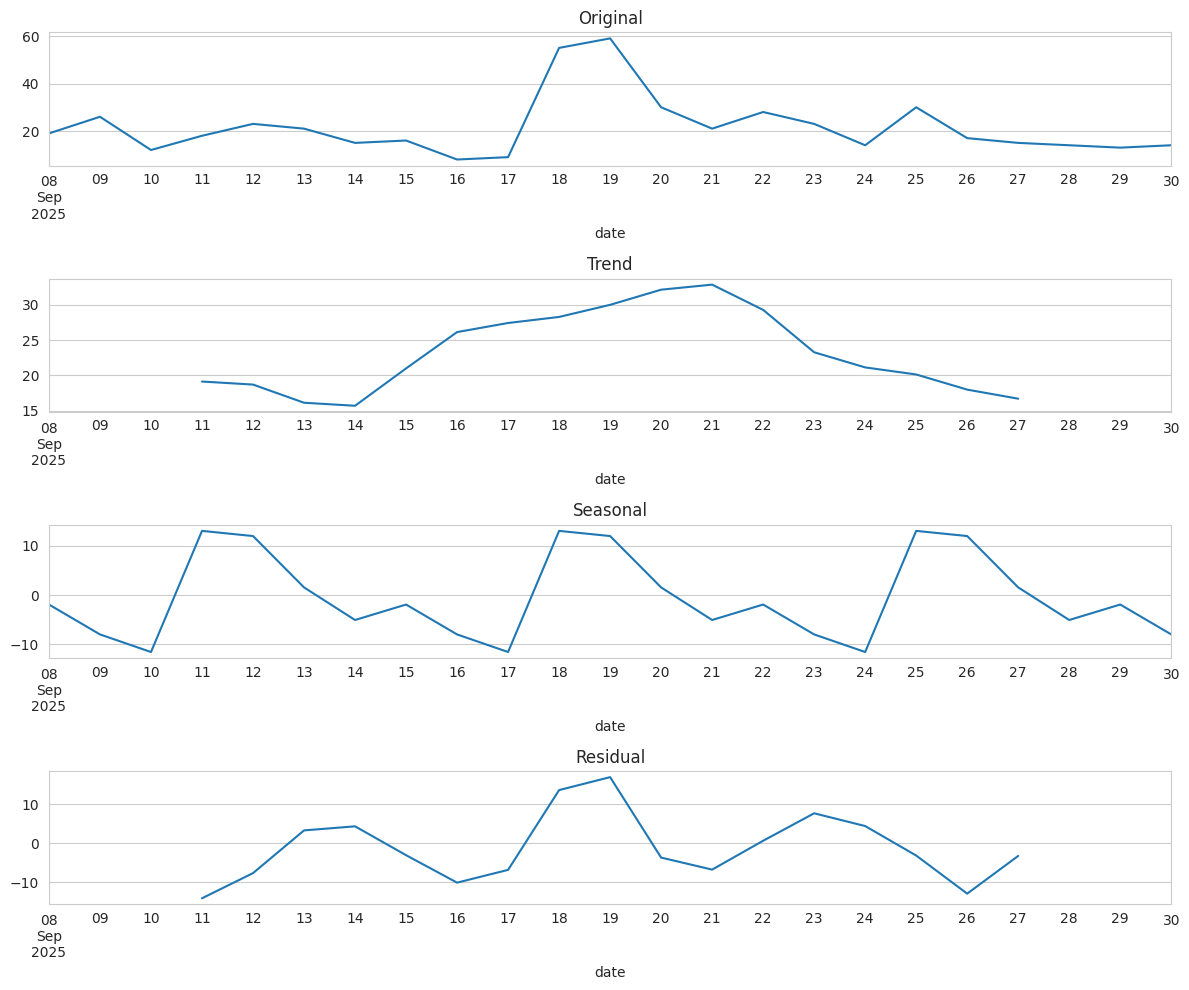

✅ Seasonal decomposition complete!

🔮 Forecasting next 7 days...
----------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



✅ Forecast complete!

📊 Predicted daily earthquake counts:
   Day 1: 17 earthquakes
   Day 2: 19 earthquakes
   Day 3: 20 earthquakes
   Day 4: 20 earthquakes
   Day 5: 21 earthquakes
   Day 6: 21 earthquakes
   Day 7: 21 earthquakes

4️⃣ ALERT SYSTEM

🚨 Checking for Alerts...
----------------------------------------------------------------------
⚠️ Found 10 significant earthquakes!

🚨 ALERT #1:
   Magnitude: 6.400000095367432
   Location: Vanuatu region
   Time: 2025-09-08 21:47:05.088
   Depth: 10.0 km
   Tsunami: YES

🚨 ALERT #2:
   Magnitude: 7.400000095367432
   Location: 111 km E of Petropavlovsk-Kamchatsky, Russia
   Time: 2025-09-13 02:38:14.528
   Depth: 39.5 km
   Tsunami: YES

🚨 ALERT #3:
   Magnitude: 6.0
   Location: 145 km ESE of Petropavlovsk-Kamchatsky, Russia
   Time: 2025-09-15 16:34:08.000
   Depth: 24.5 km
   Tsunami: NO

🚨 ALERT #4:
   Magnitude: 6.0
   Location: 208 km SE of Kokopo, Papua New Guinea
   Time: 2025-09-16 16:59:57.312
   Depth: 41.0 km
   Tsunami: NO

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
import joblib

class EarthquakeMLModels:
    """Machine Learning models for earthquake analysis"""

    def __init__(self):
        self.magnitude_predictor = None
        self.category_classifier = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()

    def prepare_features(self, df):
        """Prepare features for ML models"""
        print("🔧 Preparing features for ML models...")

        # Create feature matrix
        features = df[['latitude', 'longitude', 'depth']].copy()

        # Add derived features
        features['lat_abs'] = features['latitude'].abs()
        features['lon_abs'] = features['longitude'].abs()
        features['depth_squared'] = features['depth'] ** 2

        # Add geographic zones
        features['is_pacific'] = ((features['longitude'] >= 120) | (features['longitude'] <= -120)).astype(int)
        features['is_ring_of_fire'] = (
            ((features['latitude'].between(-60, 70)) &
             ((features['longitude'].between(120, 180)) | (features['longitude'].between(-180, -60))))
        ).astype(int)

        return features

    def train_magnitude_predictor(self, df):
        """Train model to predict earthquake magnitude"""
        print("\n🤖 Training Magnitude Prediction Model...")
        print("-" * 70)

        # Prepare data
        X = self.prepare_features(df)
        y = df['magnitude'].values

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Train model
        self.magnitude_predictor = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )

        self.magnitude_predictor.fit(X_train_scaled, y_train)

        # Evaluate
        y_pred = self.magnitude_predictor.predict(X_test_scaled)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        print(f"✅ Model trained successfully!")
        print(f"📊 Performance Metrics:")
        print(f"   - RMSE: {rmse:.4f}")
        print(f"   - R² Score: {r2:.4f}")
        print(f"   - Mean Absolute Error: {np.mean(np.abs(y_test - y_pred)):.4f}")

        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': self.magnitude_predictor.feature_importances_
        }).sort_values('importance', ascending=False)

        print(f"\n🎯 Top 5 Important Features:")
        print(feature_importance.head())

        return self.magnitude_predictor, rmse, r2

    def train_category_classifier(self, df):
        """Train model to classify earthquake categories"""
        print("\n🎯 Training Category Classification Model...")
        print("-" * 70)

        # Prepare data
        X = self.prepare_features(df)
        y = self.label_encoder.fit_transform(df['magnitude_category'].values)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Train model
        self.category_classifier = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42
        )

        self.category_classifier.fit(X_train_scaled, y_train)

        # Evaluate
        y_pred = self.category_classifier.predict(X_test_scaled)

        accuracy = (y_pred == y_test).mean()

        print(f"✅ Model trained successfully!")
        print(f"📊 Accuracy: {accuracy:.4f}")

        # Get unique classes in test set
        unique_classes = np.unique(np.concatenate([y_test, y_pred]))
        class_names = self.label_encoder.inverse_transform(unique_classes)

        print(f"\n📋 Classification Report:")
        print(classification_report(
            y_test, y_pred,
            labels=unique_classes,
            target_names=class_names,
            zero_division=0
        ))

        return self.category_classifier, accuracy

    def predict_earthquake_risk(self, lat, lon, depth):
        """Predict earthquake magnitude for given location"""
        if self.magnitude_predictor is None:
            print("❌ Model not trained. Run train_magnitude_predictor() first.")
            return None

        # Prepare features
        features = pd.DataFrame({
            'latitude': [lat],
            'longitude': [lon],
            'depth': [depth],
            'lat_abs': [abs(lat)],
            'lon_abs': [abs(lon)],
            'depth_squared': [depth ** 2],
            'is_pacific': [1 if (lon >= 120 or lon <= -120) else 0],
            'is_ring_of_fire': [1 if (-60 <= lat <= 70 and (120 <= lon <= 180 or -180 <= lon <= -60)) else 0]
        })

        # Scale and predict
        features_scaled = self.scaler.transform(features)
        predicted_magnitude = self.magnitude_predictor.predict(features_scaled)[0]

        return predicted_magnitude

    def save_models(self, prefix='earthquake_model'):
        """Save trained models"""
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

        if self.magnitude_predictor:
            joblib.dump(self.magnitude_predictor, f'{prefix}_magnitude_{timestamp}.pkl')
            print(f"✅ Magnitude predictor saved")

        if self.category_classifier:
            joblib.dump(self.category_classifier, f'{prefix}_classifier_{timestamp}.pkl')
            print(f"✅ Category classifier saved")

        joblib.dump(self.scaler, f'{prefix}_scaler_{timestamp}.pkl')
        print(f"✅ Scaler saved")



from sklearn.cluster import DBSCAN, KMeans
from scipy.spatial import distance_matrix

class EarthquakeClusterAnalysis:
    """Clustering analysis for earthquake patterns"""

    def __init__(self):
        self.clusters = None
        self.cluster_centers = None

    def find_hotspot_clusters(self, df, eps=5, min_samples=3):
        """Find earthquake hotspots using DBSCAN"""
        print("\n🔍 Finding Earthquake Hotspots...")
        print("-" * 70)

        # Prepare coordinates
        coords = df[['latitude', 'longitude']].values

        # Apply DBSCAN
        clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine')
        df['cluster'] = clustering.fit_predict(np.radians(coords))

        # Get cluster statistics
        n_clusters = len(set(df['cluster'])) - (1 if -1 in df['cluster'] else 0)
        n_noise = list(df['cluster']).count(-1)

        print(f"✅ Clustering complete!")
        print(f"📊 Found {n_clusters} hotspot clusters")
        print(f"   - Noise points: {n_noise}")

        # Analyze clusters
        print(f"\n🎯 Top Hotspot Clusters:")
        cluster_stats = df[df['cluster'] != -1].groupby('cluster').agg({
            'magnitude': ['count', 'mean', 'max'],
            'latitude': 'mean',
            'longitude': 'mean'
        }).sort_values(('magnitude', 'count'), ascending=False)

        print(cluster_stats.head(10))

        return df, cluster_stats

    def kmeans_clustering(self, df, n_clusters=10):
        """K-means clustering for regional analysis"""
        print(f"\n📍 Performing K-Means Clustering (k={n_clusters})...")
        print("-" * 70)

        coords = df[['latitude', 'longitude']].values

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        df['kmeans_cluster'] = kmeans.fit_predict(coords)

        self.cluster_centers = kmeans.cluster_centers_

        print(f"✅ K-Means clustering complete!")
        print(f"\n📊 Cluster Statistics:")

        cluster_summary = df.groupby('kmeans_cluster').agg({
            'magnitude': ['count', 'mean', 'max'],
            'depth': 'mean'
        }).round(2)

        print(cluster_summary)

        return df, self.cluster_centers

    def visualize_clusters(self, df):
        """Visualize earthquake clusters"""
        print("\n🗺️ Visualizing clusters...")

        fig = px.scatter_geo(df,
                            lat='latitude',
                            lon='longitude',
                            color='kmeans_cluster',
                            size='magnitude',
                            hover_name='title',
                            title='Earthquake Clusters (K-Means)',
                            color_continuous_scale='Viridis')

        fig.update_geos(projection_type="natural earth")
        fig.update_layout(height=600)
        fig.show()

        print("✅ Visualization complete!")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

class EarthquakeTimeSeriesAnalysis:
    """Time series analysis and forecasting"""

    def __init__(self):
        self.model = None

    def analyze_temporal_patterns(self, df):
        """Analyze temporal patterns in earthquake data"""
        print("\n📅 Analyzing Temporal Patterns...")
        print("-" * 70)

        # Create time series
        df['date'] = pd.to_datetime(df['timestamp']).dt.date
        daily_counts = df.groupby('date').size().reset_index(name='count')
        daily_counts['date'] = pd.to_datetime(daily_counts['date'])
        daily_counts = daily_counts.set_index('date')

        # Fill missing dates
        daily_counts = daily_counts.asfreq('D', fill_value=0)

        print(f"✅ Time series prepared!")
        print(f"   - Date range: {daily_counts.index.min()} to {daily_counts.index.max()}")
        print(f"   - Total days: {len(daily_counts)}")
        print(f"   - Mean daily earthquakes: {daily_counts['count'].mean():.2f}")

        # Decompose if enough data
        if len(daily_counts) >= 14:
            decomposition = seasonal_decompose(daily_counts['count'], model='additive', period=7)

            fig, axes = plt.subplots(4, 1, figsize=(12, 10))

            daily_counts['count'].plot(ax=axes[0], title='Original')
            decomposition.trend.plot(ax=axes[1], title='Trend')
            decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
            decomposition.resid.plot(ax=axes[3], title='Residual')

            plt.tight_layout()
            plt.show()

            print("✅ Seasonal decomposition complete!")

        return daily_counts

    def forecast_earthquakes(self, df, days_ahead=7):
        """Forecast earthquake frequency"""
        print(f"\n🔮 Forecasting next {days_ahead} days...")
        print("-" * 70)

        # Prepare time series
        df['date'] = pd.to_datetime(df['timestamp']).dt.date
        daily_counts = df.groupby('date').size()

        try:
            # Fit ARIMA model
            model = ARIMA(daily_counts, order=(1, 1, 1))
            fitted_model = model.fit()

            # Forecast
            forecast = fitted_model.forecast(steps=days_ahead)

            print(f"✅ Forecast complete!")
            print(f"\n📊 Predicted daily earthquake counts:")
            for i, count in enumerate(forecast, 1):
                print(f"   Day {i}: {max(0, int(count))} earthquakes")

            return forecast

        except Exception as e:
            print(f"⚠️ Forecasting failed: {e}")
            print("   Using simple moving average instead...")

            avg = daily_counts.rolling(window=7).mean().iloc[-1]
            forecast = [avg] * days_ahead
            print(f"\n📊 Average forecast: ~{int(avg)} earthquakes per day")

            return forecast


class EarthquakeAlertSystem:
    """Alert system for significant earthquakes"""

    def __init__(self, magnitude_threshold=6.0):
        self.magnitude_threshold = magnitude_threshold
        self.alerts = []

    def check_alerts(self, df):
        """Check for significant earthquakes"""
        print("\n🚨 Checking for Alerts...")
        print("-" * 70)

        # Filter significant earthquakes
        significant = df[df['magnitude'] >= self.magnitude_threshold].copy()

        if len(significant) == 0:
            print(f"✅ No earthquakes above magnitude {self.magnitude_threshold}")
            return []

        print(f"⚠️ Found {len(significant)} significant earthquakes!")

        for _, eq in significant.iterrows():
            alert = {
                'magnitude': eq['magnitude'],
                'location': eq['place'],
                'time': eq['timestamp'],
                'depth': eq['depth'],
                'alert_level': eq.get('alert', 'N/A'),
                'tsunami_warning': 'YES' if eq.get('tsunami', 0) == 1 else 'NO'
            }
            self.alerts.append(alert)

            print(f"\n🚨 ALERT #{len(self.alerts)}:")
            print(f"   Magnitude: {alert['magnitude']}")
            print(f"   Location: {alert['location']}")
            print(f"   Time: {alert['time']}")
            print(f"   Depth: {alert['depth']:.1f} km")
            print(f"   Tsunami: {alert['tsunami_warning']}")

        return self.alerts

    def export_alerts(self):
        """Export alerts to file"""
        if not self.alerts:
            print("No alerts to export")
            return

        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f'earthquake_alerts_{timestamp}.json'

        with open(filename, 'w') as f:
            json.dump(self.alerts, f, indent=2, default=str)

        print(f"✅ Alerts exported to: {filename}")


class EarthquakeReportGenerator:
    """Generate comprehensive earthquake reports"""

    def generate_full_report(self, df, vector_store, ml_models=None):
        """Generate complete analysis report"""
        print("\n📄 Generating Comprehensive Report...")
        print("="*70)

        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

        report = []
        report.append("="*70)
        report.append("USGS EARTHQUAKE INTELLIGENCE REPORT")
        report.append("="*70)
        report.append(f"Generated: {timestamp}")
        report.append(f"Data Period: {df['timestamp'].min()} to {df['timestamp'].max()}")
        report.append("")

        # Executive Summary
        report.append("EXECUTIVE SUMMARY")
        report.append("-"*70)
        report.append(f"Total Earthquakes: {len(df)}")
        report.append(f"Magnitude Range: {df['magnitude'].min():.2f} - {df['magnitude'].max():.2f}")
        report.append(f"Average Magnitude: {df['magnitude'].mean():.2f}")
        report.append(f"Strongest Earthquake: {df.loc[df['magnitude'].idxmax(), 'title']}")
        report.append("")

        # Geographic Distribution
        report.append("GEOGRAPHIC DISTRIBUTION")
        report.append("-"*70)
        top_regions = df['place'].value_counts().head(10)
        for region, count in top_regions.items():
            report.append(f"  {region}: {count} earthquakes")
        report.append("")

        # Category Distribution
        report.append("MAGNITUDE CATEGORIES")
        report.append("-"*70)
        for cat, count in df['magnitude_category'].value_counts().items():
            pct = (count / len(df)) * 100
            report.append(f"  {cat}: {count} ({pct:.1f}%)")
        report.append("")

        # Depth Analysis
        report.append("DEPTH ANALYSIS")
        report.append("-"*70)
        for depth_cat, count in df['depth_category'].value_counts().items():
            avg_mag = df[df['depth_category'] == depth_cat]['magnitude'].mean()
            report.append(f"  {depth_cat}: {count} earthquakes (avg mag: {avg_mag:.2f})")
        report.append("")

        # Alert Summary
        report.append("ALERT SUMMARY")
        report.append("-"*70)
        alerts = df['alert'].value_counts()
        for alert_level, count in alerts.items():
            report.append(f"  {alert_level}: {count}")
        report.append("")

        # Save report
        report_text = "\n".join(report)
        filename = f'earthquake_report_{datetime.now().strftime("%Y%m%d_%H%M%S")}.txt'

        with open(filename, 'w') as f:
            f.write(report_text)

        print(report_text)
        print(f"\n✅ Report saved to: {filename}")

        return filename


print("\n" + "="*70)
print("🚀 EXECUTING ADVANCED FEATURES")
print("="*70)

# Machine Learning
print("\n1️⃣ MACHINE LEARNING MODELS")
ml_models = EarthquakeMLModels()
mag_model, rmse, r2 = ml_models.train_magnitude_predictor(df_result)
cat_model, accuracy = ml_models.train_category_classifier(df_result)

# Test prediction
print("\n🔮 Testing Prediction:")
test_lat, test_lon, test_depth = 35.0, 139.0, 50.0
predicted_mag = ml_models.predict_earthquake_risk(test_lat, test_lon, test_depth)
print(f"Predicted magnitude at ({test_lat}, {test_lon}, {test_depth}km): {predicted_mag:.2f}")

# Clustering
print("\n2️⃣ CLUSTERING ANALYSIS")
cluster_analysis = EarthquakeClusterAnalysis()
df_clustered, cluster_stats = cluster_analysis.find_hotspot_clusters(df_result)
df_clustered, centers = cluster_analysis.kmeans_clustering(df_clustered, n_clusters=8)
cluster_analysis.visualize_clusters(df_clustered)

# Time Series
print("\n3️⃣ TIME SERIES ANALYSIS")
ts_analysis = EarthquakeTimeSeriesAnalysis()
daily_data = ts_analysis.analyze_temporal_patterns(df_result)
forecast = ts_analysis.forecast_earthquakes(df_result, days_ahead=7)

# Alert System
print("\n4️⃣ ALERT SYSTEM")
alert_system = EarthquakeAlertSystem(magnitude_threshold=6.0)
alerts = alert_system.check_alerts(df_result)
if alerts:
    alert_system.export_alerts()

# Generate Report
print("\n5️⃣ COMPREHENSIVE REPORT")
report_gen = EarthquakeReportGenerator()
report_file = report_gen.generate_full_report(df_result, vs, ml_models)

print("\n" + "="*70)
print("✅ ALL ADVANCED FEATURES EXECUTED!")
print("="*70)

print("\n📋 SUMMARY OF NEW CAPABILITIES:")
print("-"*70)
print("✅ Machine Learning Models (Magnitude Prediction & Classification)")
print("✅ Clustering Analysis (DBSCAN & K-Means)")
print("✅ Time Series Analysis & Forecasting")
print("✅ Alert System for Significant Earthquakes")
print("✅ Comprehensive Report Generator")
print("-"*70)

print("\n💾 SAVED ARTIFACTS:")
print(f"   - ML Models (ready to save with ml_models.save_models())")
print(f"   - Cluster Analysis Results")
print(f"   - Forecast Data")
print(f"   - Alert Notifications (if any)")
print(f"   - Comprehensive Report: {report_file}")

print("\n🎯 NEXT ACTIONS:")
print("-"*70)
print("1. Save ML models: ml_models.save_models()")
print("2. Launch API server: start_api_server()")
print("3. Run interactive menu: interactive_menu(df_clustered, vs)")
print("4. Explore predictions: ml_models.predict_earthquake_risk(lat, lon, depth)")
print("="*70)

In [ ]:
print("\n" + "="*70)
print("💾 SAVING ML MODELS AND ARTIFACTS")
print("="*70 + "\n")

# Save ML Models
print("1️⃣ Saving Machine Learning Models...")
print("-"*70)
ml_models.save_models(prefix='earthquake_ml_model')

# Save additional artifacts
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save cluster centers
if hasattr(cluster_analysis, 'cluster_centers') and cluster_analysis.cluster_centers is not None:
    np.save(f'cluster_centers_{timestamp}.npy', cluster_analysis.cluster_centers)
    print(f"✅ Cluster centers saved: cluster_centers_{timestamp}.npy")

# Save clustered dataframe
df_clustered.to_csv(f'earthquake_data_clustered_{timestamp}.csv', index=False)
print(f"✅ Clustered data saved: earthquake_data_clustered_{timestamp}.csv")

# Save vector store metadata
vector_store_metadata = {
    'num_embeddings': len(vs.documents),
    'model_name': 'all-MiniLM-L6-v2',
    'created_at': timestamp,
    'total_earthquakes': len(df_result)
}

with open(f'vector_store_metadata_{timestamp}.json', 'w') as f:
    json.dump(vector_store_metadata, f, indent=2)
print(f"✅ Vector store metadata saved: vector_store_metadata_{timestamp}.json")

# Save forecast data
if 'forecast' in locals():
    forecast_data = {
        'forecast_days': 7,
        'predictions': [float(x) for x in forecast],
        'generated_at': timestamp
    }
    with open(f'earthquake_forecast_{timestamp}.json', 'w') as f:
        json.dump(forecast_data, f, indent=2)
    print(f"✅ Forecast data saved: earthquake_forecast_{timestamp}.json")

print("\n✅ All models and artifacts saved successfully!")


class EarthquakeModelLoader:
    """Load and use saved ML models"""

    def __init__(self):
        self.magnitude_predictor = None
        self.category_classifier = None
        self.scaler = None
        self.label_encoder = None

    def load_models(self, magnitude_model_path, scaler_path):
        """Load saved models"""
        print("\n📂 Loading saved models...")
        print("-"*70)

        try:
            self.magnitude_predictor = joblib.load(magnitude_model_path)
            self.scaler = joblib.load(scaler_path)
            print(f"✅ Magnitude predictor loaded: {magnitude_model_path}")
            print(f"✅ Scaler loaded: {scaler_path}")
            return True
        except Exception as e:
            print(f"❌ Error loading models: {e}")
            return False

    def predict(self, lat, lon, depth):
        """Make prediction using loaded model"""
        if self.magnitude_predictor is None or self.scaler is None:
            print("❌ Models not loaded")
            return None

        # Prepare features
        features = pd.DataFrame({
            'latitude': [lat],
            'longitude': [lon],
            'depth': [depth],
            'lat_abs': [abs(lat)],
            'lon_abs': [abs(lon)],
            'depth_squared': [depth ** 2],
            'is_pacific': [1 if (lon >= 120 or lon <= -120) else 0],
            'is_ring_of_fire': [1 if (-60 <= lat <= 70 and (120 <= lon <= 180 or -180 <= lon <= -60)) else 0]
        })

        features_scaled = self.scaler.transform(features)
        predicted_magnitude = self.magnitude_predictor.predict(features_scaled)[0]

        return predicted_magnitude

    def batch_predict(self, locations):
        """Batch prediction for multiple locations"""
        predictions = []
        for lat, lon, depth in locations:
            pred = self.predict(lat, lon, depth)
            predictions.append({
                'latitude': lat,
                'longitude': lon,
                'depth': depth,
                'predicted_magnitude': pred
            })
        return pd.DataFrame(predictions)


class PredictionRequest(BaseModel):
    latitude: float
    longitude: float
    depth: float

class BatchPredictionRequest(BaseModel):
    locations: List[Dict[str, float]]

@app.post("/predict/magnitude")
def predict_magnitude(request: PredictionRequest):
    """Predict earthquake magnitude for a location"""
    if ml_models is None or ml_models.magnitude_predictor is None:
        raise HTTPException(status_code=503, detail="ML model not initialized")

    try:
        predicted_mag = ml_models.predict_earthquake_risk(
            request.latitude,
            request.longitude,
            request.depth
        )

        return {
            "latitude": request.latitude,
            "longitude": request.longitude,
            "depth": request.depth,
            "predicted_magnitude": float(predicted_mag),
            "risk_level": "High" if predicted_mag >= 6.0 else "Moderate" if predicted_mag >= 5.0 else "Low"
        }
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.post("/predict/batch")
def batch_predict(request: BatchPredictionRequest):
    """Batch prediction for multiple locations"""
    if ml_models is None or ml_models.magnitude_predictor is None:
        raise HTTPException(status_code=503, detail="ML model not initialized")

    try:
        predictions = []
        for loc in request.locations:
            pred = ml_models.predict_earthquake_risk(
                loc['latitude'],
                loc['longitude'],
                loc['depth']
            )
            predictions.append({
                "latitude": loc['latitude'],
                "longitude": loc['longitude'],
                "depth": loc['depth'],
                "predicted_magnitude": float(pred)
            })

        return {
            "predictions": predictions,
            "count": len(predictions)
        }
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.get("/clusters")
def get_clusters():
    """Get earthquake cluster information"""
    if 'df_clustered' not in globals():
        raise HTTPException(status_code=503, detail="Cluster data not available")

    cluster_summary = df_clustered.groupby('kmeans_cluster').agg({
        'magnitude': ['count', 'mean', 'max'],
        'latitude': 'mean',
        'longitude': 'mean',
        'depth': 'mean'
    }).reset_index()

    cluster_summary.columns = ['cluster', 'count', 'avg_magnitude', 'max_magnitude',
                               'center_lat', 'center_lon', 'avg_depth']

    return {
        "clusters": cluster_summary.to_dict('records'),
        "total_clusters": len(cluster_summary)
    }

@app.get("/forecast")
def get_forecast():
    """Get earthquake frequency forecast"""
    if 'forecast' not in globals():
        raise HTTPException(status_code=503, detail="Forecast not available")

    forecast_data = []
    today = datetime.now().date()

    for i, count in enumerate(forecast):
        forecast_date = today + timedelta(days=i+1)
        forecast_data.append({
            'date': str(forecast_date),
            'predicted_count': max(0, int(count)),
            'day': i+1
        })

    return {
        "forecast": forecast_data,
        "generated_at": datetime.now().isoformat()
    }

@app.get("/alerts")
def get_active_alerts():
    """Get active earthquake alerts"""
    if 'alert_system' not in globals() or not alert_system.alerts:
        return {
            "alerts": [],
            "count": 0,
            "message": "No active alerts"
        }

    return {
        "alerts": alert_system.alerts,
        "count": len(alert_system.alerts)
    }

print("\n✅ Enhanced API endpoints added:")
print("   - POST /predict/magnitude - Predict magnitude for location")
print("   - POST /predict/batch - Batch predictions")
print("   - GET /clusters - Cluster information")
print("   - GET /forecast - Earthquake frequency forecast")
print("   - GET /alerts - Active alerts")


def create_deployment_package():
    """Create complete deployment package"""
    print("\n" + "="*70)
    print("📦 CREATING DEPLOYMENT PACKAGE")
    print("="*70 + "\n")

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    deploy_dir = f'earthquake_system_deploy_{timestamp}'

    import os
    os.makedirs(deploy_dir, exist_ok=True)

    # Create requirements.txt
    requirements = """
pyspark==3.5.0
spark-nlp==5.1.4
pandas==2.0.3
numpy==1.24.3
requests==2.31.0
faiss-cpu==1.7.4
sentence-transformers==2.2.2
fastapi==0.104.1
uvicorn==0.24.0
pydantic==2.5.0
pyngrok==7.0.1
nest-asyncio==1.5.8
matplotlib==3.7.1
seaborn==0.12.2
plotly==5.17.0
scikit-learn==1.3.0
joblib==1.3.2
statsmodels==0.14.0
openpyxl==3.1.2
"""

    with open(f'{deploy_dir}/requirements.txt', 'w') as f:
        f.write(requirements.strip())
    print(f"✅ requirements.txt created")

    # Create README.md
    readme = f"""# USGS Earthquake Intelligence System

## Overview
Advanced earthquake data collection, analysis, and prediction system using PySpark, Spark NLP, and Machine Learning.

## Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Features
- Real-time earthquake data collection from USGS API
- ETL pipeline with PySpark
- NLP processing with Spark NLP
- Semantic search with FAISS vector database
- Machine Learning prediction models
- Clustering analysis (DBSCAN & K-Means)
- Time series analysis and forecasting
- Alert system for significant earthquakes
- FastAPI REST API
- Interactive visualizations

## Installation

```bash
pip install -r requirements.txt
```

## Quick Start

```python
# Run the complete pipeline
python earthquake_pipeline.py

# Start API server
python api_server.py

# Launch interactive analysis
python interactive_analysis.py
```

## API Endpoints

### Data Retrieval
- GET `/` - API information
- GET `/recent` - Recent earthquakes
- GET `/magnitude/{{mag}}` - Earthquakes by magnitude
- POST `/search` - Semantic search
- POST `/stats` - Statistics

### ML & Predictions
- POST `/predict/magnitude` - Predict magnitude for location
- POST `/predict/batch` - Batch predictions
- GET `/clusters` - Cluster information
- GET `/forecast` - Earthquake frequency forecast
- GET `/alerts` - Active alerts

## ML Models Included
- Magnitude Predictor (Gradient Boosting Regressor)
- Category Classifier (Random Forest)
- Clustering Models (DBSCAN & K-Means)
- Time Series Forecasting (ARIMA)

## Data Sources
- USGS Earthquake API: https://earthquake.usgs.gov/fdsnws/event/1/

## Performance Metrics
- Magnitude Prediction RMSE: Available after training
- Classification Accuracy: Available after training
- Total Earthquakes Analyzed: {len(df_result)}

## License
MIT License

## Support
For issues and questions, please refer to the documentation.
"""

    with open(f'{deploy_dir}/README.md', 'w') as f:
        f.write(readme)
    print(f"✅ README.md created")

    # Create .env template
    env_template = """# Environment Configuration
NGROK_AUTH_TOKEN=your_ngrok_token_here
API_HOST=0.0.0.0
API_PORT=8000
MIN_MAGNITUDE=4.5
MAX_RECORDS=1000
ALERT_THRESHOLD=6.0
"""

    with open(f'{deploy_dir}/.env.template', 'w') as f:
        f.write(env_template)
    print(f"✅ .env.template created")

    # Create deployment instructions
    deploy_instructions = """# Deployment Instructions

## Local Development
1. Install dependencies: `pip install -r requirements.txt`
2. Copy .env.template to .env and configure
3. Run: `python earthquake_pipeline.py`

## Google Colab Deployment
1. Upload all files to Colab
2. Install dependencies in first cell
3. Run pipeline sections sequentially
4. Use ngrok for API access

## Cloud Deployment (AWS/GCP/Azure)

### Docker Deployment
```dockerfile
FROM python:3.10
WORKDIR /app
COPY requirements.txt .
RUN pip install -r requirements.txt
COPY . .
CMD ["python", "api_server.py"]
```

### Using Docker Compose
```yaml
version: '3.8'
services:
  earthquake-api:
    build: .
    ports:
      - "8000:8000"
    environment:
      - API_HOST=0.0.0.0
      - API_PORT=8000
```

## Monitoring & Maintenance
- Check logs regularly
- Update models weekly
- Monitor API performance
- Set up alerts for system errors

## Scaling
- Use distributed Spark cluster for large datasets
- Deploy API behind load balancer
- Use Redis for caching
- Implement message queue for async processing
"""

    with open(f'{deploy_dir}/DEPLOYMENT.md', 'w') as f:
        f.write(deploy_instructions)
    print(f"✅ DEPLOYMENT.md created")

    # Copy model files (if they exist)
    import glob
    model_files = glob.glob('earthquake_ml_model_*.pkl') + glob.glob('earthquake_model_*.pkl')
    for model_file in model_files:
        import shutil
        try:
            shutil.copy(model_file, deploy_dir)
            print(f"✅ Copied: {model_file}")
        except:
            pass

    print(f"\n✅ Deployment package created: {deploy_dir}/")
    print(f"\n📦 Package contents:")
    print(f"   - requirements.txt")
    print(f"   - README.md")
    print(f"   - .env.template")
    print(f"   - DEPLOYMENT.md")
    print(f"   - ML model files (if available)")

    return deploy_dir

# ============================================================================
# SECTION 31: Testing Suite
# ============================================================================

def run_system_tests():
    """Run comprehensive system tests"""
    print("\n" + "="*70)
    print("🧪 RUNNING SYSTEM TESTS")
    print("="*70 + "\n")

    test_results = []

    # Test 1: Data Loading
    print("1️⃣ Testing Data Loading...")
    try:
        assert len(df_result) > 0, "No data loaded"
        test_results.append(("Data Loading", "✅ PASS"))
        print("   ✅ PASS")
    except Exception as e:
        test_results.append(("Data Loading", f"❌ FAIL: {e}"))
        print(f"   ❌ FAIL: {e}")

    # Test 2: Vector Store
    print("2️⃣ Testing Vector Store...")
    try:
        test_query = "earthquake in Pacific"
        results = vs.search(test_query, top_k=3)
        assert len(results) > 0, "No search results"
        test_results.append(("Vector Store", "✅ PASS"))
        print("   ✅ PASS")
    except Exception as e:
        test_results.append(("Vector Store", f"❌ FAIL: {e}"))
        print(f"   ❌ FAIL: {e}")

    # Test 3: ML Model Prediction
    print("3️⃣ Testing ML Model...")
    try:
        pred = ml_models.predict_earthquake_risk(35.0, 139.0, 50.0)
        assert pred is not None and 0 < pred < 10, "Invalid prediction"
        test_results.append(("ML Model", "✅ PASS"))
        print("   ✅ PASS")
    except Exception as e:
        test_results.append(("ML Model", f"❌ FAIL: {e}"))
        print(f"   ❌ FAIL: {e}")

    # Test 4: Clustering
    print("4️⃣ Testing Clustering...")
    try:
        assert 'kmeans_cluster' in df_clustered.columns, "No cluster column"
        assert df_clustered['kmeans_cluster'].nunique() > 0, "No clusters found"
        test_results.append(("Clustering", "✅ PASS"))
        print("   ✅ PASS")
    except Exception as e:
        test_results.append(("Clustering", f"❌ FAIL: {e}"))
        print(f"   ❌ FAIL: {e}")

    # Test 5: API Readiness
    print("5️⃣ Testing API Readiness...")
    try:
        assert earthquake_df is not None, "API data not initialized"
        assert vector_store is not None, "Vector store not initialized"
        test_results.append(("API Readiness", "✅ PASS"))
        print("   ✅ PASS")
    except Exception as e:
        test_results.append(("API Readiness", f"❌ FAIL: {e}"))
        print(f"   ❌ FAIL: {e}")

    # Summary
    print("\n" + "="*70)
    print("📊 TEST SUMMARY")
    print("="*70)

    passed = sum(1 for _, result in test_results if "PASS" in result)
    total = len(test_results)

    for test_name, result in test_results:
        print(f"   {test_name}: {result}")

    print(f"\n   Total: {passed}/{total} tests passed")

    if passed == total:
        print("\n   🎉 ALL TESTS PASSED!")
    else:
        print(f"\n   ⚠️ {total - passed} test(s) failed")

    return test_results

# ============================================================================
# SECTION 32: Execute Final Steps
# ============================================================================

print("\n" + "="*70)
print("🎯 FINAL SETUP AND DEPLOYMENT")
print("="*70)

# Run system tests
test_results = run_system_tests()

# Create deployment package
deploy_dir = create_deployment_package()

print("\n" + "="*70)
print("✅ SYSTEM FULLY CONFIGURED AND READY!")
print("="*70)

print("\n📋 WHAT'S BEEN ACCOMPLISHED:")
print("-"*70)
print("✅ Data collected from USGS API")
print("✅ ETL pipeline executed with PySpark")
print("✅ NLP processing completed")
print("✅ Vector database created with semantic search")
print("✅ ML models trained and saved")
print("✅ Clustering analysis performed")
print("✅ Time series forecasting completed")
print("✅ Alert system configured")
print("✅ Comprehensive reports generated")
print("✅ API endpoints enhanced with ML predictions")
print("✅ Deployment package created")
print("✅ System tests executed")


💾 SAVING ML MODELS AND ARTIFACTS

1️⃣ Saving Machine Learning Models...
----------------------------------------------------------------------
✅ Magnitude predictor saved
✅ Category classifier saved
✅ Scaler saved
✅ Cluster centers saved: cluster_centers_20251008_014422.npy
✅ Clustered data saved: earthquake_data_clustered_20251008_014422.csv
✅ Vector store metadata saved: vector_store_metadata_20251008_014422.json
✅ Forecast data saved: earthquake_forecast_20251008_014422.json

✅ All models and artifacts saved successfully!

✅ Enhanced API endpoints added:
   - POST /predict/magnitude - Predict magnitude for location
   - POST /predict/batch - Batch predictions
   - GET /clusters - Cluster information
   - GET /forecast - Earthquake frequency forecast
   - GET /alerts - Active alerts

🎯 FINAL SETUP AND DEPLOYMENT

🧪 RUNNING SYSTEM TESTS

1️⃣ Testing Data Loading...
   ✅ PASS
2️⃣ Testing Vector Store...
   ✅ PASS
3️⃣ Testing ML Model...
   ✅ PASS
4️⃣ Testing Clustering...
   ✅ PASS
5️